In [1]:
###############################################################################
# CELL 1: IMPORTS AND LIBRARIES
###############################################################################
"""
Face GAN - Deep Convolutional GAN for Face Generation
----------------------------------------------------
Import required libraries and modules for dataset processing,
neural network creation, training, and visualization.
"""
import os
import re
import sys
import time
import json
import random
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter progress bars

# Try importing optional libraries
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_AVAILABLE = True
except ImportError:
    TENSORBOARD_AVAILABLE = False
    print("TensorBoard not available. Install with: pip install tensorboard")

# For resource monitoring
try:
    import psutil
    import GPUtil
    RESOURCE_MONITORING = True
except ImportError:
    RESOURCE_MONITORING = False
    print("Resource monitoring unavailable. Install with: pip install psutil gputil")

# Set display settings for the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)


In [2]:
###############################################################################
# CELL 2: CONFIGURATION SETTINGS
###############################################################################
"""
Configuration Settings
---------------------
Define paths, hyperparameters, and training settings.
Modify these values to adapt the model to your specific requirements.
"""
# Paths
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
CELEBDF_PATH = os.path.join(BASE_DIR, "faces\\Real\\Celeb_V2\\Train\\real")
FF_PATH = os.path.join(BASE_DIR, "faces\\Real\\FaceForensics++\\original_sequences\\youtube\\c23\\frames")
PROCESSED_PATH = os.path.join(BASE_DIR, "processed_faces")
OUTPUT_PATH = os.path.join(BASE_DIR, "output")
CHECKPOINT_DIR = os.path.join(OUTPUT_PATH, "checkpoints")
LOG_DIR = os.path.join(OUTPUT_PATH, "logs")

# Dataset processing settings
PROCESS_DATASETS = False  # Set to False to skip dataset processing if already processed
CELEBDF_MAX_PER_FACE = None  # Max images per face for CelebDF
FF_MAX_PER_FACE = None  # Max images per face for FaceForensics++
FF_MAX_FACES = None  # Maximum number of different faces from FaceForensics++
TARGET_SIZE = 128  # Size to resize images to

# Model hyperparameters
CUDA = True  # Use CUDA (will be auto-detected later)
BATCH_SIZE = 64
IMAGE_CHANNEL = 3  # RGB images
Z_DIM = 100  # Latent vector dimension
G_HIDDEN = 128
D_HIDDEN = 128
X_DIM = 128  # Target image size
EPOCH_NUM = 20  # Number of training epochs
lr = 2e-4  # Learning rate
seed = 1  # Random seed for reproducibility

# Training control settings
CHECKPOINT_FREQ = 5  # Save checkpoints every N epochs
CHECKPOINT_SAMPLES = 1000  # Generate image samples every N iterations
RESUME_TRAINING = True  # Try to resume from checkpoint if available
EARLY_STOPPING_PATIENCE = 5  # Early stopping after N epochs without improvement
EARLY_STOPPING_THRESHOLD = 0.01  # Minimum improvement to reset patience counter
RESOURCE_CHECK_FREQ = 50  # Check system resources every N batches
MAX_TRAINING_TIME = None  # Max training time in hours (None for no limit)
ENABLE_TENSORBOARD = TENSORBOARD_AVAILABLE  # Enable TensorBoard logging
EXPERIMENT_NAME = f"face_gan_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"  # Unique name for this run

# Print some key configuration values
print(f"Dataset paths:\n- CelebDF: {CELEBDF_PATH}\n- FaceForensics++: {FF_PATH}")
print(f"Processed data will be saved to: {PROCESSED_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")
print(f"Target image size: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {EPOCH_NUM}")


Dataset paths:
- CelebDF: c:\Users\vinay\Documents\mnist\faces\Real\Celeb_V2\Train\real
- FaceForensics++: c:\Users\vinay\Documents\mnist\faces\Real\FaceForensics++\original_sequences\youtube\c23\frames
Processed data will be saved to: c:\Users\vinay\Documents\mnist\processed_faces
Output will be saved to: c:\Users\vinay\Documents\mnist\output
Target image size: 128x128
Batch size: 64
Training epochs: 20


In [3]:
###############################################################################
# CELL 3: HELPER FUNCTIONS
###############################################################################
"""
Helper Functions
--------------
Create output directories, verify dataset paths,
save configuration, and monitor system resources.
"""
def create_output_directories():
    """Create necessary output directories"""
    os.makedirs(PROCESSED_PATH, exist_ok=True)
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(LOG_DIR, exist_ok=True)
    
    # Create separate directories for each dataset
    celebdf_dir = os.path.join(PROCESSED_PATH, "celebdf")
    ff_dir = os.path.join(PROCESSED_PATH, "faceforensics")
    combined_dir = os.path.join(PROCESSED_PATH, "combined")
    
    os.makedirs(celebdf_dir, exist_ok=True)
    os.makedirs(ff_dir, exist_ok=True)
    os.makedirs(combined_dir, exist_ok=True)
    
    print(f"Created output directories:")
    print(f" - CelebDF: {celebdf_dir}")
    print(f" - FaceForensics++: {ff_dir}")
    print(f" - Combined: {combined_dir}")
    print(f" - Results: {OUTPUT_PATH}")
    print(f" - Checkpoints: {CHECKPOINT_DIR}")
    print(f" - Logs: {LOG_DIR}")
    
    return celebdf_dir, ff_dir, combined_dir

def verify_dataset_paths():
    """Verify that dataset paths exist"""
    celebdf_exists = os.path.exists(CELEBDF_PATH)
    ff_exists = os.path.exists(FF_PATH)
    
    print(f"CelebDF dataset: {'Found' if celebdf_exists else 'Not found'} at {CELEBDF_PATH}")
    print(f"FaceForensics++ dataset: {'Found' if ff_exists else 'Not found'} at {FF_PATH}")
    
    return celebdf_exists, ff_exists

def save_config():
    """Save current configuration as a JSON file"""
    config = {
        'CELEBDF_PATH': CELEBDF_PATH,
        'FF_PATH': FF_PATH,
        'PROCESSED_PATH': PROCESSED_PATH,
        'OUTPUT_PATH': OUTPUT_PATH,
        'CHECKPOINT_DIR': CHECKPOINT_DIR,
        'PROCESS_DATASETS': PROCESS_DATASETS,
        'CELEBDF_MAX_PER_FACE': CELEBDF_MAX_PER_FACE,
        'FF_MAX_PER_FACE': FF_MAX_PER_FACE,
        'FF_MAX_FACES': FF_MAX_FACES,
        'TARGET_SIZE': TARGET_SIZE,
        'BATCH_SIZE': BATCH_SIZE,
        'IMAGE_CHANNEL': IMAGE_CHANNEL,
        'Z_DIM': Z_DIM,
        'G_HIDDEN': G_HIDDEN,
        'D_HIDDEN': D_HIDDEN,
        'X_DIM': X_DIM,
        'EPOCH_NUM': EPOCH_NUM,
        'lr': lr,
        'seed': seed,
        'EXPERIMENT_NAME': EXPERIMENT_NAME,
        'timestamp': datetime.datetime.now().isoformat()
    }
    
    config_path = os.path.join(OUTPUT_PATH, f"{EXPERIMENT_NAME}_config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"Configuration saved to {config_path}")
    return config_path

def monitor_resources():
    """Monitor system resources and return a report"""
    if not RESOURCE_MONITORING:
        return "Resource monitoring unavailable. Install psutil and gputil."
    
    # CPU info
    cpu_percent = psutil.cpu_percent(interval=1)
    memory = psutil.virtual_memory()
    memory_percent = memory.percent
    
    # GPU info
    gpu_info = "No GPU available"
    if torch.cuda.is_available():
        try:
            gpus = GPUtil.getGPUs()
            if gpus:
                gpu = gpus[0]  # Get the first GPU
                gpu_name = gpu.name
                gpu_load = f"{gpu.load * 100:.1f}%"
                gpu_mem_used = f"{gpu.memoryUsed:.0f}MB"
                gpu_mem_total = f"{gpu.memoryTotal:.0f}MB"
                gpu_mem_percent = f"{(gpu.memoryUsed / gpu.memoryTotal) * 100:.1f}%"
                gpu_temp = f"{gpu.temperature}°C"
                gpu_info = f"{gpu_name}: {gpu_load} load, {gpu_mem_used}/{gpu_mem_total} ({gpu_mem_percent}), {gpu_temp}"
        except Exception as e:
            gpu_info = f"Error getting GPU info: {e}"
    
    return {
        "cpu_percent": cpu_percent,
        "memory_percent": memory_percent,
        "gpu_info": gpu_info,
        "timestamp": datetime.datetime.now().isoformat()
    }

# Create directories and verify paths
celebdf_dir, ff_dir, combined_dir = create_output_directories()
celebdf_exists, ff_exists = verify_dataset_paths()
save_config()


Created output directories:
 - CelebDF: c:\Users\vinay\Documents\mnist\processed_faces\celebdf
 - FaceForensics++: c:\Users\vinay\Documents\mnist\processed_faces\faceforensics
 - Combined: c:\Users\vinay\Documents\mnist\processed_faces\combined
 - Results: c:\Users\vinay\Documents\mnist\output
 - Checkpoints: c:\Users\vinay\Documents\mnist\output\checkpoints
 - Logs: c:\Users\vinay\Documents\mnist\output\logs
CelebDF dataset: Found at c:\Users\vinay\Documents\mnist\faces\Real\Celeb_V2\Train\real
FaceForensics++ dataset: Found at c:\Users\vinay\Documents\mnist\faces\Real\FaceForensics++\original_sequences\youtube\c23\frames
Configuration saved to c:\Users\vinay\Documents\mnist\output\face_gan_20250327_181453_config.json


'c:\\Users\\vinay\\Documents\\mnist\\output\\face_gan_20250327_181453_config.json'

In [4]:

###############################################################################
# CELL 4: CELEBDF DATASET PROCESSING
###############################################################################
"""
CelebDF Dataset Processing
------------------------
Process the CelebDF dataset by extracting faces, resizing them,
and saving them to a standardized format.
"""
def process_celebdf_dataset(source_dir, target_dir, target_size=(128, 128), max_images=None):
    """Process CelebDF dataset where all images are in a single folder"""
    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    if not source_path.exists():
        print(f"Source directory {source_path} does not exist.")
        return 0
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(source_path.glob(f"*{ext}"))
        image_files.extend(source_path.glob(f"*{ext.upper()}"))
    
    # If maximum image limit is set, randomly sample
    if max_images and len(image_files) > max_images:
        random.seed(1)  # For reproducible results
        image_files = random.sample(image_files, max_images)
    
    print(f"Found {len(image_files)} total images in {source_path}")
    
    # Process all images directly with progress bar
    count = 0
    with tqdm(total=len(image_files), desc="Processing CelebDF images", unit="img") as pbar:
        for img_path in image_files:
            try:
                # Open and resize image
                img = Image.open(img_path)
                img = img.resize(target_size, Image.LANCZOS)
                
                # Save to target directory
                target_file = target_path / f"celebdf_{count:06d}{img_path.suffix}"
                img.save(target_file)
                count += 1
                pbar.update(1)
                    
            except Exception as e:
                print(f"\nError processing {img_path.name}: {e}")
    
    print(f"Successfully processed {count} images from CelebDF to {target_path}")
    return count

# Only run if PROCESS_DATASETS is True and CelebDF dataset exists
if PROCESS_DATASETS and celebdf_exists:
    count = process_celebdf_dataset(
        CELEBDF_PATH, 
        celebdf_dir, 
        target_size=(TARGET_SIZE, TARGET_SIZE),
        max_images=None  # Set to None to process all images, or a number to limit
    )
    print(f"Processed {count} CelebDF images")
else:
    print("Skipping CelebDF processing. Set PROCESS_DATASETS=True to process.")


Skipping CelebDF processing. Set PROCESS_DATASETS=True to process.


In [5]:
###############################################################################
# CELL 5: FACEFORENSICS++ DATASET PROCESSING
###############################################################################
"""
FaceForensics++ Dataset Processing
-------------------------------
Process the FaceForensics++ dataset by extracting face folders,
resizing images, and saving them to a standardized format.
"""
def process_faceforensics_dataset(source_dir, target_dir, target_size=(128, 128), max_folders=None, max_images_per_folder=None):
    """Process FaceForensics++ dataset where images are organized in numbered folders"""
    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    if not source_path.exists():
        print(f"Source directory {source_path} does not exist.")
        return 0
    
    # Get all folders in the source directory
    face_folders = [f for f in source_path.iterdir() if f.is_dir()]
    
    # Limit number of folders if specified
    if max_folders and len(face_folders) > max_folders:
        face_folders = random.sample(face_folders, max_folders)
    
    print(f"Found {len(face_folders)} face folders in {source_path}")
    
    # Count total images to process for progress bar
    total_images = 0
    folder_image_counts = []
    for folder in face_folders:
        image_files = []
        for ext in ['.jpg', '.jpeg', '.png']:
            image_files.extend(folder.glob(f"*{ext}"))
            image_files.extend(folder.glob(f"*{ext.upper()}"))
        
        count = len(image_files)
        if max_images_per_folder and count > max_images_per_folder:
            count = max_images_per_folder
        
        folder_image_counts.append(count)
        total_images += count
    
    # Process images in each folder with progress bar
    count = 0
    with tqdm(total=total_images, desc="Processing FaceForensics++ images", unit="img") as pbar:
        for folder_idx, folder in enumerate(face_folders):
            # Get image files in this folder
            image_files = []
            for ext in ['.jpg', '.jpeg', '.png']:
                image_files.extend(folder.glob(f"*{ext}"))
                image_files.extend(folder.glob(f"*{ext.upper()}"))
            
            # Limit number of images per folder if specified
            if max_images_per_folder and len(image_files) > max_images_per_folder:
                image_files = random.sample(image_files, max_images_per_folder)
            
                try:
                    # Open and resize image
                    img = Image.open(img_path)
                    img = img.resize(target_size, Image.LANCZOS)
                    
                    # Save to target directory with folder index as face ID
                    target_file = target_path / f"ff_{folder_idx:04d}_{img_idx:04d}{img_path.suffix}"
                    img.save(target_file)
                    count += 1
                    pbar.update(1)
                        
                except Exception as e:
                    print(f"\nError processing {img_path.name}: {e}")
    
    print(f"Successfully processed {count} images from FaceForensics++ to {target_path}")
    return count

In [6]:
# Only run if PROCESS_DATASETS is True and FaceForensics++ dataset exists
if PROCESS_DATASETS and ff_exists:
    count = process_faceforensics_dataset(
        FF_PATH, 
        ff_dir, 
        target_size=(TARGET_SIZE, TARGET_SIZE),
        max_folders=FF_MAX_FACES,
        max_images_per_folder=FF_MAX_PER_FACE
    )
    print(f"Processed {count} FaceForensics++ images")
else:
    print("Skipping FaceForensics++ processing. Set PROCESS_DATASETS=True to process.")


Skipping FaceForensics++ processing. Set PROCESS_DATASETS=True to process.


In [7]:
###############################################################################
# CELL 6: COMBINE DATASETS
###############################################################################
"""
Dataset Combination
----------------
Combine the processed CelebDF and FaceForensics++ datasets 
into a single dataset for training. This ensures we have a diverse
set of facial images.
"""
def combine_datasets(celebdf_dir, ff_dir, combined_dir):
    """Combine processed datasets into one directory"""
    # Copy all images from CelebDF directory
    celebdf_files = list(Path(celebdf_dir).glob("*.jpg")) + list(Path(celebdf_dir).glob("*.png"))
    ff_files = list(Path(ff_dir).glob("*.jpg")) + list(Path(ff_dir).glob("*.png"))
    
    total_files = len(celebdf_files) + len(ff_files)
    print(f"Combining {len(celebdf_files)} CelebDF images and {len(ff_files)} FaceForensics++ images...")
    
    with tqdm(total=total_files, desc="Combining datasets", unit="img") as pbar:
        # Copy CelebDF images
        for img_path in celebdf_files:
            try:
                target_path = Path(combined_dir) / img_path.name
                img = Image.open(img_path)
                img.save(target_path)
                pbar.update(1)
            except Exception as e:
                print(f"\nError copying {img_path.name}: {e}")
        
        # Copy FaceForensics++ images
        for img_path in ff_files:
            try:
                target_path = Path(combined_dir) / img_path.name
                img = Image.open(img_path)
                img.save(target_path)
                pbar.update(1)
            except Exception as e:
                print(f"\nError copying {img_path.name}: {e}")
    
    print(f"Combined dataset created with {total_files} total images at {combined_dir}")
    return total_files

# Only run if both datasets have been processed
if PROCESS_DATASETS and celebdf_exists and ff_exists:
    total_images = combine_datasets(celebdf_dir, ff_dir, combined_dir)
    dataset_path = combined_dir
    print(f"Combined dataset created with {total_images} images")
elif celebdf_exists and os.path.exists(celebdf_dir) and len(os.listdir(celebdf_dir)) > 0:
    dataset_path = celebdf_dir
    print(f"Using CelebDF dataset at {celebdf_dir}")
elif ff_exists and os.path.exists(ff_dir) and len(os.listdir(ff_dir)) > 0:
    dataset_path = ff_dir
    print(f"Using FaceForensics++ dataset at {ff_dir}")
elif os.path.exists(combined_dir) and len(os.listdir(combined_dir)) > 0:
    dataset_path = combined_dir
    print(f"Using existing combined dataset at {combined_dir}")
else:
    print("Error: No datasets were processed or found")
    dataset_path = None

print(f"Dataset path for training: {dataset_path}")


Using CelebDF dataset at c:\Users\vinay\Documents\mnist\processed_faces\celebdf
Dataset path for training: c:\Users\vinay\Documents\mnist\processed_faces\celebdf


In [8]:

###############################################################################
# CELL 7: DATASET CLASS AND CUDA SETUP
###############################################################################
"""
Dataset Class and CUDA Setup
-------------------------
Define the custom dataset class for loading face images
and set up CUDA for GPU acceleration if available.
"""
class FaceDataset(Dataset):
    """Custom Dataset for loading face images"""
    def __init__(self, root_dir, transform=None, file_extensions=('.png', '.jpg', '.jpeg')):
        self.root_dir = root_dir
        self.transform = transform
        self.file_extensions = file_extensions
        
        # Count all files first for debugging
        all_files = os.listdir(root_dir)
        print(f"Total files in directory: {len(all_files)}")
        
        # Get valid image files
        self.image_files = [
            f for f in all_files 
            if os.path.isfile(os.path.join(root_dir, f)) and 
               any(f.lower().endswith(ext) for ext in self.file_extensions)
        ]
        
        # Log file extension stats
        extensions = {}
        for f in self.image_files:
            ext = os.path.splitext(f)[1].lower()
            extensions[ext] = extensions.get(ext, 0) + 1
        
        print(f"Found {len(self.image_files)} valid images out of {len(all_files)} total files")
        print(f"Image extension breakdown: {extensions}")
        
        # Check for potentially problematic files
        non_image_files = len(all_files) - len(self.image_files)
        if non_image_files > 0:
            print(f"Warning: {non_image_files} files were skipped (not recognized as images)")
            # Sample some skipped files for debugging
            skipped = [f for f in all_files if f not in self.image_files][:5]
            print(f"Sample skipped files: {skipped}")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, 0  # Return 0 as dummy label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a placeholder black image if loading fails
            if self.transform:
                return torch.zeros(3, 128, 128), 0
            else:
                return Image.new('RGB', (128, 128), color='black'), 0

def setup_cuda():
    """Setup CUDA if available"""
    global CUDA, device
    # Set random seed for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    
    if not torch.cuda.is_available():
        CUDA = False
        print("CUDA is not available. Running on CPU.")
        device = torch.device("cpu")
    else:
        device = torch.device("cuda:0")
        # Enable deterministic behavior for reproducibility
        torch.cuda.manual_seed(seed)
        cudnn.benchmark = True
    
    print(f"PyTorch version: {torch.__version__}")
    if CUDA:
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Using device: {device}")
    return device

# Setup CUDA
device = setup_cuda()


PyTorch version: 2.6.0+cu126
CUDA version: 12.6
GPU: NVIDIA GeForce RTX 2070 Super with Max-Q Design
Using device: cuda:0


In [9]:
###############################################################################
# CELL 8: GAN MODEL ARCHITECTURE
###############################################################################
"""
GAN Model Architecture
-------------------
Define the Generator and Discriminator architecture
for the Deep Convolutional GAN (DCGAN).
"""
# Replace your current Generator class with this improved version
class Generator(nn.Module):
    """Generator Network with residual connections and improved capacity"""
    def __init__(self):
        super(Generator, self).__init__()
        
        # Multi-stage transposed convolution pipeline with residuals
        self.initial = nn.Sequential(
            # Input: Z_DIM x 1 x 1
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 16),
            nn.LeakyReLU(0.2, inplace=True)
            # 4x4
        )
        
        # Stage 1: 4x4 -> 8x8
        self.stage1 = nn.Sequential(
            nn.ConvTranspose2d(G_HIDDEN * 16, G_HIDDEN * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Stage 2: 8x8 -> 16x16
        self.stage2 = nn.Sequential(
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Stage 3: 16x16 -> 32x32
        self.stage3 = nn.Sequential(
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Stage 4: 32x32 -> 64x64
        self.stage4 = nn.Sequential(
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final stage: 64x64 -> 128x128
        self.final = nn.Sequential(
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
        # Residual connections for better gradient flow
        self.res1 = self._make_residual(G_HIDDEN * 8)
        self.res2 = self._make_residual(G_HIDDEN * 4)
        self.res3 = self._make_residual(G_HIDDEN * 2)
        
    def _make_residual(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, input):
        # Initial stage
        x = self.initial(input)
        # Main stages with residual connections
        x = self.stage1(x)
        res = self.res1(x)
        x = x + 0.2 * res #Or 0.3

        x = self.stage2(x)
        res = self.res2(x)
        x = x + 0.2 * res #Or 0.3

        x = self.stage3(x)
        res = self.res3(x)
        x = x + 0.2 * res #Or 0.3
        '''
        # Main stages with residual connections
        x = self.stage1(x)
        res = self.res1(x)
        x = x + 0.1 * res
        
        x = self.stage2(x)
        res = self.res2(x)
        x = x + 0.1 * res
        
        x = self.stage3(x)
        res = self.res3(x)
        x = x + 0.1 * res
        '''
        x = self.stage4(x)
        
        # Final stage
        return self.final(x)


# Replace your current Discriminator class with this improved version
class Discriminator(nn.Module):
    """Discriminator Network with spectral normalization and deeper architecture"""
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Feature extraction pipeline
        self.model = nn.Sequential(
            # Input: IMAGE_CHANNEL x 128 x 128
            self._spectral_norm(nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # 64x64
            
            self._spectral_norm(nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32
            
            self._spectral_norm(nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16
            
            self._spectral_norm(nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8
            
            self._spectral_norm(nn.Conv2d(D_HIDDEN * 8, D_HIDDEN * 16, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(D_HIDDEN * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # 4x4
            
            self._spectral_norm(nn.Conv2d(D_HIDDEN * 16, 1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
            # 1x1
        )
    
    def _spectral_norm(self, module):
        # Simple wrapper for spectral normalization - helps stabilize training
        return nn.utils.spectral_norm(module)
    
    def forward(self, input):
        return self.model(input).view(-1)


# Initialize networks
netG = Generator().to(device)
netD = Discriminator().to(device)

# Special initialization for networks with residual connections
def weights_init_enhanced(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the enhanced initialization
netG.apply(weights_init_enhanced)
netD.apply(weights_init_enhanced)

# Optimizers with improved learning rates
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower learning rate for G
optimizerD = optim.Adam(netD.parameters(), lr=0.0004, betas=(0.5, 0.999))  # Higher learning rate for D

print("Enhanced Generator initialized")
print("Enhanced Discriminator initialized")



Enhanced Generator initialized
Enhanced Discriminator initialized


In [10]:

###############################################################################
# CELL 9: DATA LOADING WITH ENHANCED DIAGNOSTICS (VISUALIZATION REMOVED)
###############################################################################
"""
Data Loading with Enhanced Diagnostics
---------------------------
Load the processed face dataset with better diagnostics and file handling.
Includes checks for the combined directory and detailed file reporting.
Visualization has been removed to improve performance.
"""
def load_dataset(data_path):
    """Load face dataset and create dataloader with detailed diagnostics"""
    # Image transformations
    transform = transforms.Compose([
        transforms.Resize(X_DIM),
        transforms.CenterCrop(X_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB
    ])
    
    # Create dataset and dataloader
    try:
        print(f"Looking for images in: {data_path}")
        
        # Check if the directory exists and is readable
        if not os.path.exists(data_path):
            print(f"Error: Directory {data_path} does not exist")
            return None, None
        elif not os.access(data_path, os.R_OK):
            print(f"Error: No read permissions for {data_path}")
            return None, None
            
        # Check if path is combined dir and has more images
        combined_dir = os.path.join(PROCESSED_PATH, "combined")
        if os.path.exists(combined_dir) and data_path != combined_dir:
            combined_count = len([f for f in os.listdir(combined_dir) 
                               if os.path.isfile(os.path.join(combined_dir, f)) and 
                               f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            current_count = len([f for f in os.listdir(data_path) 
                               if os.path.isfile(os.path.join(data_path, f)) and 
                               f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            
            if combined_count > current_count:
                print(f"Note: The combined directory has {combined_count} images, but you're using {data_path} with {current_count} images")
                print(f"Consider using the combined dataset at {combined_dir} instead")
                
                # Optionally, switch to the combined directory automatically
                # Uncomment the line below to use the combined directory with more images
                # data_path = combined_dir
                
        # Instantiate the dataset with additional file extensions
        dataset = FaceDataset(
            root_dir=data_path, 
            transform=transform,
            file_extensions=('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')  # Add more image types
        )
        
        if len(dataset) == 0:
            print(f"Error: No valid images found in {data_path}")
            return None, None
            
        dataloader = DataLoader(
            dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=True,
            num_workers=0, 
            pin_memory=True if CUDA else False
        )
        print(f"Dataset loaded with {len(dataset)} images")
        print(f"Number of batches: {len(dataloader)}")
        return dataset, dataloader
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Load dataset if path exists
if dataset_path and os.path.exists(dataset_path):
    # Check if combined dataset exists and has more images than current dataset
    combined_dir = os.path.join(PROCESSED_PATH, "combined")
    if os.path.exists(combined_dir):
        # Quick count of valid images in both directories
        combined_files = [f for f in os.listdir(combined_dir) 
                         if os.path.isfile(os.path.join(combined_dir, f)) and 
                         f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        current_files = [f for f in os.listdir(dataset_path) 
                        if os.path.isfile(os.path.join(dataset_path, f)) and 
                        f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"Dataset comparison: Current path has {len(current_files)} images, Combined directory has {len(combined_files)} images")
        
        if len(combined_files) > len(current_files):
            print(f"Switching to combined dataset with more images: {combined_dir}")
            dataset_path = combined_dir
    
    dataset, dataloader = load_dataset(dataset_path)
    if not dataset or not dataloader:
        print("Failed to load dataset or create dataloader.")
else:
    print("Dataset path not available. Please check your configurations.")
    dataloader = None


Dataset comparison: Current path has 80576 images, Combined directory has 144473 images
Switching to combined dataset with more images: c:\Users\vinay\Documents\mnist\processed_faces\combined
Looking for images in: c:\Users\vinay\Documents\mnist\processed_faces\combined
Total files in directory: 144473
Found 144473 valid images out of 144473 total files
Image extension breakdown: {'.jpg': 80576, '.png': 63897}
Dataset loaded with 144473 images
Number of batches: 2258


In [11]:
###############################################################################
# CELL 10: CHECKPOINT FUNCTIONS
###############################################################################
"""
Checkpoint Functions
----------------
Functions for saving and loading model checkpoints
to support resumable training and best model selection.
"""
def save_checkpoint(netG, netD, optimG, optimD, epoch, iteration, losses, img_list, filename=None):
    """Save a checkpoint of the current training state"""
    if not filename:
        filename = os.path.join(CHECKPOINT_DIR, f"checkpoint_e{epoch}_i{iteration}.pt")
    
    checkpoint = {
        'epoch': epoch,
        'iteration': iteration,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimG_state_dict': optimG.state_dict(),
        'optimD_state_dict': optimD.state_dict(),
        'G_losses': losses['G'],
        'D_losses': losses['D'],
        'img_list': img_list,
        'timestamp': datetime.datetime.now().isoformat()
    }
    
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")
    
    # Save the latest checkpoint also (for resuming)
    latest_path = os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt")
    torch.save(checkpoint, latest_path)
    
    return filename



def load_checkpoint(netG, netD, optimG, optimD, filename=None):
    """Load a checkpoint to resume training with improved error handling"""
    if not filename:
        # Try to load the latest checkpoint
        filename = os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt")
    
    if not os.path.exists(filename):
        print(f"No checkpoint found at {filename}")
        return None, 0, 0, {'G': [], 'D': []}, []
    
    print(f"Loading checkpoint: {filename}")
    checkpoint = torch.load(filename, map_location=device)
    
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    
    # Fix for different key names - check both versions of keys
    if 'optimizerG_state_dict' in checkpoint:
        optimG.load_state_dict(checkpoint['optimizerG_state_dict'])
    elif 'optimG_state_dict' in checkpoint:
        optimG.load_state_dict(checkpoint['optimG_state_dict'])
        
    if 'optimizerD_state_dict' in checkpoint:
        optimD.load_state_dict(checkpoint['optimizerD_state_dict'])
    elif 'optimD_state_dict' in checkpoint:
        optimD.load_state_dict(checkpoint['optimD_state_dict'])
    
    # For optimizers loaded from checkpoint, move to correct device
    if CUDA:
        for state in optimG.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)
                    
        for state in optimD.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)
    
    # Handle missing keys with defaults
    epoch = checkpoint.get('epoch', 0)
    
    # Handle different iteration key names or missing keys
    iteration = 0
    if 'iteration' in checkpoint:
        iteration = checkpoint['iteration']
    elif 'global_step' in checkpoint:
        iteration = checkpoint['global_step']
    
    G_losses = checkpoint.get('G_losses', [])
    D_losses = checkpoint.get('D_losses', [])
    img_list = checkpoint.get('img_list', [])
    
    print(f"Resuming from epoch {epoch+1}, iteration {iteration}")
    
    return {'netG': netG, 'netD': netD, 'optimG': optimG, 'optimD': optimD}, epoch, iteration, {'G': G_losses, 'D': D_losses}, img_list




In [12]:
###############################################################################
# CELL 11: TRAINING INITIALIZATION
###############################################################################
"""
Training Initialization
--------------------
Initialize GAN training by setting up optimizers, 
creating fixed noise for visualization,
and loading a checkpoint if resuming training.
"""
# Setup loss function and optimizers
criterion = nn.BCELoss()
# Fixed noise for visualization
fixed_noise = torch.randn(16, Z_DIM, 1, 1, device=device)

# Initialize optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Setup TensorBoard
if ENABLE_TENSORBOARD:
    tb_writer = SummaryWriter(log_dir=os.path.join(LOG_DIR, EXPERIMENT_NAME))
    # Add model graph to TensorBoard
    try:
        sample_input = torch.randn(1, Z_DIM, 1, 1, device=device)
        tb_writer.add_graph(netG, sample_input)
    except Exception as e:
        print(f"Could not add model graph to TensorBoard: {e}")
else:
    tb_writer = None

# Try to load checkpoint if resuming training
start_epoch = 0
start_iter = 0
G_losses = []
D_losses = []
img_list = []

if RESUME_TRAINING:
    models, start_epoch, start_iter, losses, prev_img_list = load_checkpoint(netG, netD, optimizerG, optimizerD)
    if models:  # If checkpoint was loaded successfully
        netG, netD = models['netG'], models['netD']
        optimizerG, optimizerD = models['optimG'], models['optimD']
        G_losses = losses['G']
        D_losses = losses['D']
        img_list = prev_img_list
        print(f"Resuming from epoch {start_epoch+1}, iteration {start_iter}")

print(f"\n{'='*50}\nREADY FOR TRAINING\n{'='*50}")


No checkpoint found at c:\Users\vinay\Documents\mnist\output\checkpoints\latest_checkpoint.pt

READY FOR TRAINING


In [ ]:
# %%
###############################################################################
# CELL 12: ENHANCED TRAINING LOOP WITH STABILIZATION TECHNIQUES & WINDOWS FIX
###############################################################################
"""
Enhanced Training Loop for Face GAN (Modified for Stability & Windows)
----------------------------------
Features:
- Adjusted Learning Rates (TTUR experimentation)
- Increased DataLoader Workers with `if __name__ == '__main__':` guard for Windows
- Refined Label Smoothing / Noise
- Multiple Generator Updates per Discriminator Update
- Run-specific output directories
- Conditional/Frequency based Discriminator updates
"""
import time
import os
import csv
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Ensure tqdm.notebook is imported
import datetime
import traceback # For detailed error printing

# This guard is crucial for multiprocessing (`num_workers > 0`) on Windows
if __name__ == '__main__':

    # --- Essential Dependency Check ---
    if 'dataset' not in globals() or dataset is None:
        print("ERROR: 'dataset' not loaded or is None. Please run Cell 9 successfully first.")
        # Optionally raise an error or exit
        # raise RuntimeError("Dataset not available. Ensure Cell 9 ran correctly.")
        exit() # Stop execution if dataset isn't ready

    # --- Configuration ---
    NUM_WORKERS = 0 # Adjust based on your CPU cores (start with 2 or 4)
    BASE_LR = lr # Get base LR from Cell 2 (e.g., 2e-4)
    CHECKPOINT_FREQ_EPOCHS = 1 # Save checkpoint every N epochs
    SAVE_IMAGE_FREQ_STEPS = 200 # Save sample images every N steps
    RECORD_FREQ_STEPS = 100 # Log metrics every N steps
    GENERATOR_UPDATES_PER_ITER = 2 # Number of times to update G per iteration
    DISCRIMINATOR_UPDATE_FREQ = 1 # Update D every N iterations (1 = every iter)
    DISCRIMINATOR_CONDITIONAL_UPDATE = True # Use D(x)/D(G(z)) thresholds?
    D_UPDATE_THRESH_DX_LOWER = 0.8 # Update D if D(x) is below this
    D_UPDATE_THRESH_DGZ_UPPER = 0.2 # OR if D(G(z)) is above this

    # --- Learning Rate Strategy (TTUR Adjustment) ---
    # Option 1: Make Discriminator slower
    lr_g = BASE_LR * 1.0
    lr_d = BASE_LR * 0.5
    # Option 2: Equal Rates
    # lr_g = BASE_LR
    # lr_d = BASE_LR
    # Option 3: Less Aggressive standard TTUR
    # lr_g = BASE_LR * 0.8
    # lr_d = BASE_LR * 1.0

    print(f"Using Base LR: {BASE_LR}, Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    print(f"Using {NUM_WORKERS} DataLoader workers.")

    # --- Define Noisy Labels Function ---
    def noisy_labels(size, value, noise_level=0.1, device=None):
        """Applies one-sided label smoothing or adds noise."""
        if value > 0.5:  # Real label (target is 1.0)
            smooth_target = 0.9 # One-sided smoothing
            label = torch.full(size, smooth_target, device=device)
            # Optional tiny noise around 0.9
            label += (torch.rand(size, device=device) * noise_level * 0.5) - (noise_level * 0.25)
        else:  # Fake label (target is 0.0)
            label = torch.zeros(size, device=device)
            label += torch.rand(size, device=device) * noise_level # Noise from 0 to noise_level
        # Clamp to ensure labels are valid probabilities
        label = torch.clamp(label, 0.0, 1.0)
        return label

    # --- Setup Run-Specific Output Directories ---
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"face_gan_run_{timestamp}"
    run_dir = os.path.join(OUTPUT_PATH, run_name)

    images_dir = os.path.join(run_dir, "images")
    # Use the globally defined CHECKPOINT_DIR, but maybe within a run-specific subfolder
    run_checkpoint_dir = os.path.join(CHECKPOINT_DIR, run_name)
    logs_dir = os.path.join(run_dir, "logs")
    timelapse_dir = os.path.join(run_dir, "timelapse")

    # Create timelapse subdirectories
    angles = ["grid", "row", "individual", "interpolation"]
    timelapse_subdirs = {}
    for angle in angles:
        dir_path = os.path.join(timelapse_dir, angle)
        os.makedirs(dir_path, exist_ok=True)
        timelapse_subdirs[angle] = dir_path

    # Create all other directories
    for dir_path in [run_dir, images_dir, run_checkpoint_dir, logs_dir]:
        os.makedirs(dir_path, exist_ok=True)

    print(f"Created output directory structure at {run_dir}")
    print(f"Checkpoints for this run will be saved in: {run_checkpoint_dir}")

    # --- GPU Optimization ---
    if CUDA: # Assumes CUDA and device are set globally
        torch.backends.cudnn.benchmark = True
        # Note: 'high' precision might not be supported everywhere, 'medium' is safer default
        try:
            torch.set_float32_matmul_precision('medium') # Or 'high' if supported
        except AttributeError:
            print("Note: torch.set_float32_matmul_precision not available in this PyTorch version.")

    # --- DataLoader ---
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if CUDA else False,
        drop_last=True # Important for stable batch sizes
    )
    print(f"DataLoader created with {len(dataloader)} batches per epoch.")

    # --- Initialize Models (Assume netG, netD are defined globally) ---
    # Ensure models are on the correct device
    netG = netG.to(device)
    netD = netD.to(device)

    # --- Initialize Optimizers ---
    optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

    # --- Loss Function ---
    criterion = nn.BCELoss()

    # --- Checkpoint Loading (if resuming) ---
    start_epoch = 0
    global_step = 0
    G_losses = []
    D_losses = []
    D_x_history = []
    D_G_z_history = []
    img_list = [] # List to store sample grids for animation/final viz

    if RESUME_TRAINING: # RESUME_TRAINING flag from Cell 2
        # Use the global CHECKPOINT_DIR to find the latest overall checkpoint
        latest_checkpoint_path = os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt")
        if os.path.exists(latest_checkpoint_path):
            print(f"Loading checkpoint: {latest_checkpoint_path}")
            try:
                checkpoint = torch.load(latest_checkpoint_path, map_location=device)
                netG.load_state_dict(checkpoint['netG_state_dict'])
                netD.load_state_dict(checkpoint['netD_state_dict'])

                # --- Optimizer Loading Strategy ---
                # Option A: Load optimizer states (if LR hasn't changed drastically)
                try:
                   optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
                   optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
                   # If CUDA, ensure optimizer states are on the correct device
                   if CUDA:
                       for state in optimizerG.state.values():
                           for k, v in state.items():
                               if torch.is_tensor(v):
                                   state[k] = v.to(device)
                       for state in optimizerD.state.values():
                           for k, v in state.items():
                               if torch.is_tensor(v):
                                   state[k] = v.to(device)
                   print("Loaded optimizer states from checkpoint.")
                except KeyError as e:
                   print(f"Warning: Optimizer state key missing ({e}). Optimizers not loaded.")
                except Exception as e:
                   print(f"Warning: Could not load optimizer states: {e}. Optimizers not loaded.")

                # Option B: Don't load optimizer states (useful if changing LR significantly)
                # print("Skipping optimizer state loading due to potential LR change.")

                start_epoch = checkpoint.get('epoch', 0) + 1 # Start from next epoch
                global_step = checkpoint.get('global_step', 0)
                G_losses = checkpoint.get('G_losses', [])
                D_losses = checkpoint.get('D_losses', [])
                D_x_history = checkpoint.get('D_x_history', [])
                D_G_z_history = checkpoint.get('D_G_z_history', [])
                # img_list is usually not saved/loaded in checkpoints due to size
                print(f"Resuming from Epoch {start_epoch + 1}, Global Step {global_step}")
                print(f"Loaded {len(G_losses)} previous loss records.")

            except Exception as e:
                print(f"Error loading checkpoint: {e}. Starting from scratch.")
                start_epoch = 0
                global_step = 0
        else:
            print("No checkpoint found at 'latest_checkpoint.pt'. Starting from scratch.")
    else:
         print("Starting training from scratch.")


    # --- Setup for Visualization & Logging ---
    fixed_noise = torch.randn(25, Z_DIM, 1, 1, device=device) # For grid
    fixed_noise_row = torch.randn(8, Z_DIM, 1, 1, device=device) # For row
    interpolation_points = 10
    fixed_noise_start = torch.randn(1, Z_DIM, 1, 1, device=device)
    fixed_noise_end = torch.randn(1, Z_DIM, 1, 1, device=device)
    interpolation_noises = []
    for i in range(interpolation_points):
        t = i / (interpolation_points - 1)
        interp_noise = (1-t) * fixed_noise_start + t * fixed_noise_end
        interpolation_noises.append(interp_noise)

    csv_log_path = os.path.join(logs_dir, "training_metrics.csv")
    # Write header only if starting from scratch or file doesn't exist
    if global_step == 0 or not os.path.exists(csv_log_path):
        with open(csv_log_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Epoch', 'Step', 'Global_Step', 'G_loss', 'D_loss', 'D_x', 'D_G_z1', 'D_G_z2',
                             'Time_elapsed_s', 'ETA_s'])

    # --- Timelapse Image Saving Function ---
    def save_timelapse_images(netG, current_global_step):
        filename_base = f"{current_global_step:07d}" # Use global step for unique filenames
        grid_img_tensor = None
        try:
            netG.eval() # Set model to evaluation mode for generation
            with torch.no_grad():
                # Grid
                fake_grid = netG(fixed_noise).detach().cpu()
                grid_img_tensor = vutils.make_grid(fake_grid, padding=2, normalize=True, nrow=5)
                grid_filename = os.path.join(timelapse_subdirs["grid"], f"grid_{filename_base}.png")
                vutils.save_image(fake_grid, grid_filename, nrow=5, padding=2, normalize=True)

                # Row
                fake_row = netG(fixed_noise_row).detach().cpu()
                row_filename = os.path.join(timelapse_subdirs["row"], f"row_{filename_base}.png")
                vutils.save_image(fake_row, row_filename, nrow=8, padding=2, normalize=True)

                # Individual
                indiv_samples = netG(fixed_noise[:4]).detach().cpu()
                for i, sample in enumerate(indiv_samples):
                    indiv_filename = os.path.join(timelapse_subdirs["individual"], f"img{i}_{filename_base}.png")
                    vutils.save_image(sample, indiv_filename, normalize=True)

                # Interpolation
                interp_images = [netG(noise).detach().cpu() for noise in interpolation_noises]
                interp_tensor = torch.cat(interp_images, 0)
                interp_filename = os.path.join(timelapse_subdirs["interpolation"], f"interp_{filename_base}.png")
                vutils.save_image(interp_tensor, interp_filename, nrow=interpolation_points, normalize=True)
            netG.train() # Set model back to training mode
        except Exception as e:
            print(f"\nError saving timelapse images at step {current_global_step}: {e}")
            netG.train() # Ensure model is back in train mode even if error occurred
        return grid_img_tensor # Return the grid tensor for potential animation later


    # --- Training Start ---
    print("Starting Training Loop...")
    start_time = time.time()
    total_iterations_estimate = len(dataloader) * (EPOCH_NUM - start_epoch) # Estimate remaining iterations

    main_progress = tqdm(total=total_iterations_estimate, desc="Total Progress", initial=0) # Initial is 0, update manually

    try:
        for epoch in range(start_epoch, EPOCH_NUM):
            epoch_start_time = time.time()
            pbar = tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCH_NUM}", leave=False)

            for i, data in enumerate(dataloader):

                # --- Data Preparation ---
                real_images = data[0].to(device)
                current_batch_size = real_images.size(0)

                # Check for batch size mismatch (can happen with drop_last=False)
                if current_batch_size != BATCH_SIZE and i != len(dataloader) -1 : # Allow last batch if drop_last=False
                     print(f"Warning: Batch size mismatch ({current_batch_size} != {BATCH_SIZE}). Skipping batch.")
                     continue

                # ==================================================================
                #                      Train Discriminator
                # ==================================================================
                netD.zero_grad()

                # --- Real Batch ---
                # Use noisy labels for real data (target smoothed towards 0.9)
                real_label_values = noisy_labels((current_batch_size,), 1.0, noise_level=0.05, device=device) # Less noise maybe
                output_real = netD(real_images).view(-1) # Flatten output
                errD_real = criterion(output_real, real_label_values)
                errD_real.backward()
                D_x = output_real.mean().item() # Average D output for real images

                # --- Fake Batch ---
                noise = torch.randn(current_batch_size, Z_DIM, 1, 1, device=device)
                fake_images = netG(noise) # Generate fake images
                # Use noisy labels for fake data (target noisy around 0.0)
                fake_label_values = noisy_labels((current_batch_size,), 0.0, noise_level=0.1, device=device)
                output_fake = netD(fake_images.detach()).view(-1) # Detach G's graph
                errD_fake = criterion(output_fake, fake_label_values)
                errD_fake.backward()
                D_G_z1 = output_fake.mean().item() # Average D output for fake images (before G update)

                # --- Total Discriminator Loss and Update ---
                errD = errD_real + errD_fake

                # Conditional / Frequency Update Logic
                do_update_D = False
                if global_step % DISCRIMINATOR_UPDATE_FREQ == 0:
                    if DISCRIMINATOR_CONDITIONAL_UPDATE:
                        if D_x < D_UPDATE_THRESH_DX_LOWER or D_G_z1 > D_UPDATE_THRESH_DGZ_UPPER:
                            do_update_D = True
                    else: # Update based on frequency only
                        do_update_D = True

                if do_update_D:
                    optimizerD.step()

                # ==================================================================
                #                        Train Generator
                # ==================================================================
                # Update Generator multiple times
                errG_accum = 0.0
                output_fake_final = None # To store output after last G update
                for _ in range(GENERATOR_UPDATES_PER_ITER):
                    netG.zero_grad()
                    # Generate fresh fake images for each G update step
                    noise = torch.randn(current_batch_size, Z_DIM, 1, 1, device=device)
                    fake_images = netG(noise)
                    output_fake_final = netD(fake_images).view(-1)

                    # Generator aims to make Discriminator output 1 (REAL)
                    # Use standard non-noisy 'real' labels as target for G
                    real_targets_for_G = torch.ones_like(output_fake_final)
                    errG = criterion(output_fake_final, real_targets_for_G)
                    errG_accum += errG.item() # Accumulate loss for logging average
                    errG.backward()
                    optimizerG.step()

                errG_avg = errG_accum / GENERATOR_UPDATES_PER_ITER
                D_G_z2 = output_fake_final.mean().item() # D output for fake images (after G updates)


                # ==================================================================
                #                  Logging, Visualization, Checkpointing
                # ==================================================================

                # --- Record Losses ---
                G_losses.append(errG_avg)
                D_losses.append(errD.item())
                D_x_history.append(D_x)
                D_G_z_history.append(D_G_z2) # Log D(G(z)) *after* G update

                # --- Progress Bar Update ---
                pbar.set_postfix({
                    'G_loss': f"{errG_avg:.3f}",
                    'D_loss': f"{errD.item():.3f}",
                    'D(x)': f"{D_x:.3f}",
                    'D(G(z))': f"{D_G_z2:.3f}" # Show D(G(z)) after G update
                })
                pbar.update(1)
                if global_step < total_iterations_estimate + start_epoch * len(dataloader): # Prevent overshooting initial estimate
                     main_progress.update(1)


                # --- CSV Logging ---
                if global_step % RECORD_FREQ_STEPS == 0:
                    elapsed_time_s = time.time() - start_time
                    steps_done = global_step - (start_epoch * len(dataloader))
                    total_steps_remaining = total_iterations_estimate - steps_done
                    eta_s = (elapsed_time_s / steps_done * total_steps_remaining) if steps_done > 0 else 0
                    try:
                        with open(csv_log_path, 'a', newline='') as csvfile:
                            writer = csv.writer(csvfile)
                            writer.writerow([
                                epoch + 1, i + 1, global_step, errG_avg, errD.item(),
                                D_x, D_G_z1, D_G_z2,
                                elapsed_time_s, eta_s
                            ])
                    except Exception as log_e:
                        print(f"\nError writing to CSV log: {log_e}")


                # --- Save Timelapse Images ---
                if global_step % SAVE_IMAGE_FREQ_STEPS == 0 or (epoch == EPOCH_NUM - 1 and i == len(dataloader) - 1):
                    grid_tensor = save_timelapse_images(netG, global_step)
                    if grid_tensor is not None:
                         img_list.append(grid_tensor) # Store grid for final animation/plot

                    # Optional: Save loss curve plot frequently
                    try:
                         plt.figure(figsize=(10, 8))
                         plt.subplot(2, 1, 1)
                         plt.title(f"Losses up to Step {global_step}")
                         plt.plot(G_losses, label="G")
                         plt.plot(D_losses, label="D")
                         plt.legend()
                         plt.grid(True)
                         plt.subplot(2, 1, 2)
                         plt.title(f"Discriminator Outputs up to Step {global_step}")
                         plt.plot(D_x_history, label="D(x)")
                         plt.plot(D_G_z_history, label="D(G(z))")
                         plt.axhline(y=0.5, color='r', linestyle='--', label='Ideal Equil.')
                         plt.legend()
                         plt.grid(True)
                         plt.tight_layout()
                         plt.savefig(os.path.join(logs_dir, f"loss_curves_{global_step:07d}.png"))
                         plt.close()
                    except Exception as plot_e:
                         print(f"\nError saving loss plot: {plot_e}")


                # --- Increment Global Step ---
                global_step += 1

            # --- End of Epoch ---
            pbar.close()
            epoch_time = time.time() - epoch_start_time
            print(f"Epoch {epoch+1}/{EPOCH_NUM} completed in {epoch_time:.2f}s")

            # --- Save Checkpoint ---
            if (epoch + 1) % CHECKPOINT_FREQ_EPOCHS == 0 or epoch == EPOCH_NUM - 1:
                chkpt_data = {
                    'epoch': epoch,
                    'global_step': global_step,
                    'netG_state_dict': netG.state_dict(),
                    'netD_state_dict': netD.state_dict(),
                    'optimizerG_state_dict': optimizerG.state_dict(),
                    'optimizerD_state_dict': optimizerD.state_dict(),
                    'G_losses': G_losses,
                    'D_losses': D_losses,
                    'D_x_history': D_x_history,
                    'D_G_z_history': D_G_z_history,
                    'timestamp': datetime.datetime.now().isoformat()
                 }
                # Save epoch-specific checkpoint in run's checkpoint dir
                epoch_checkpoint_path = os.path.join(run_checkpoint_dir, f"checkpoint_epoch_{epoch+1:03d}.pt")
                torch.save(chkpt_data, epoch_checkpoint_path)
                print(f"Epoch checkpoint saved: {epoch_checkpoint_path}")

                # Also save as the latest OVERALL checkpoint (for easy resuming)
                latest_overall_path = os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt")
                torch.save(chkpt_data, latest_overall_path)
                # print(f"Updated latest overall checkpoint: {latest_overall_path}") # Less verbose


        # --- Training Complete ---
        main_progress.close()
        total_time = time.time() - start_time
        print(f"\n{'='*30}\nTraining Finished!\n{'='*30}")
        print(f"Total training time: {str(datetime.timedelta(seconds=int(total_time)))}")

        # --- Save Final Summary Plot ---
        plt.figure(figsize=(16, 8))
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(G_losses, label="Generator Loss")
        plt.plot(D_losses, label="Discriminator Loss")
        plt.title("Loss During Training")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # D(x)/D(G(z)) plot
        plt.subplot(1, 2, 2)
        plt.plot(D_x_history, label="D(x) - Avg on Real")
        plt.plot(D_G_z_history, label="D(G(z)) - Avg on Fake")
        plt.axhline(y=0.5, color='r', linestyle='--', label='Ideal Equil.')
        plt.title("Discriminator Outputs")
        plt.xlabel("Iterations")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "final_summary_plots.png"))
        plt.close() # Close plot to prevent display in notebook if not desired

        # --- Save Final Models ---
        torch.save(netG.state_dict(), os.path.join(run_dir, "generator_final.pt"))
        torch.save(netD.state_dict(), os.path.join(run_dir, "discriminator_final.pt"))

        print(f"Final models and summary saved to {run_dir}")

    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
        main_progress.close()
        # Optionally save an interruption checkpoint here if needed

    except Exception as e:
        print(f"\nAn error occurred during training:")
        print(traceback.format_exc()) # Print detailed traceback
        main_progress.close()

        # --- Attempt Emergency Save ---
        print("Attempting to save emergency checkpoint...")
        try:
            emergency_path = os.path.join(run_checkpoint_dir, "emergency_checkpoint.pt")
            torch.save({
                'epoch': epoch if 'epoch' in locals() else -1, # Save last known epoch
                'global_step': global_step,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
                'D_x_history': D_x_history,
                'D_G_z_history': D_G_z_history,
                'timestamp': datetime.datetime.now().isoformat()
            }, emergency_path)
            print(f"Emergency checkpoint saved to {emergency_path}")
            # Also try updating latest overall
            latest_overall_path = os.path.join(CHECKPOINT_DIR, "latest_checkpoint.pt")
            torch.save({ # Save same data as emergency
                'epoch': epoch if 'epoch' in locals() else -1,
                'global_step': global_step,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
                'D_x_history': D_x_history,
                'D_G_z_history': D_G_z_history,
                'timestamp': datetime.datetime.now().isoformat()
            }, latest_overall_path)

        except Exception as save_e:
            print(f"Failed to save emergency checkpoint: {save_e}")

# End of `if __name__ == '__main__':` block

Using Base LR: 0.0002, Generator LR: 0.0002, Discriminator LR: 0.0001
Using 0 DataLoader workers.
Created output directory structure at c:\Users\vinay\Documents\mnist\output\face_gan_run_20250327_181526
Checkpoints for this run will be saved in: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526
DataLoader created with 2257 batches per epoch.
No checkpoint found at 'latest_checkpoint.pt'. Starting from scratch.
Starting Training Loop...


Total Progress:   0%|          | 0/45140 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 1/20 completed in 3812.24s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_001.pt


Epoch 2/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 2/20 completed in 3754.25s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_002.pt


Epoch 3/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 3/20 completed in 3907.85s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_003.pt


Epoch 4/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 4/20 completed in 3740.56s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_004.pt


Epoch 5/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 5/20 completed in 3709.71s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_005.pt


Epoch 6/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 6/20 completed in 3724.81s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_006.pt


Epoch 7/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 7/20 completed in 3735.31s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_007.pt


Epoch 8/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 8/20 completed in 3737.31s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_008.pt


Epoch 9/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 9/20 completed in 3734.72s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_009.pt


Epoch 10/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 10/20 completed in 3764.65s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_010.pt


Epoch 11/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 11/20 completed in 3999.89s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_011.pt


Epoch 12/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 12/20 completed in 3926.89s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_012.pt


Epoch 13/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 13/20 completed in 3844.22s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_013.pt


Epoch 14/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 14/20 completed in 3886.72s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_014.pt


Epoch 15/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 15/20 completed in 3801.58s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_015.pt


Epoch 16/20:   0%|          | 0/2257 [00:00<?, ?it/s]

Epoch 16/20 completed in 3781.79s
Epoch checkpoint saved: c:\Users\vinay\Documents\mnist\output\checkpoints\face_gan_run_20250327_181526\checkpoint_epoch_016.pt


Epoch 17/20:   0%|          | 0/2257 [00:00<?, ?it/s]

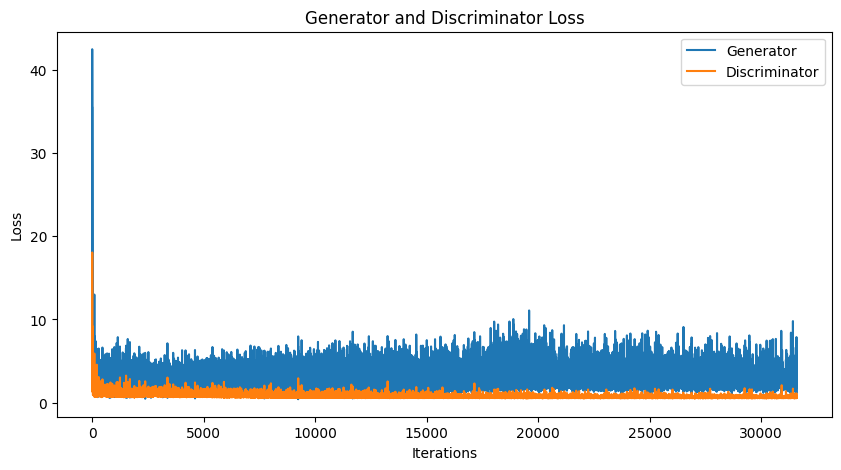

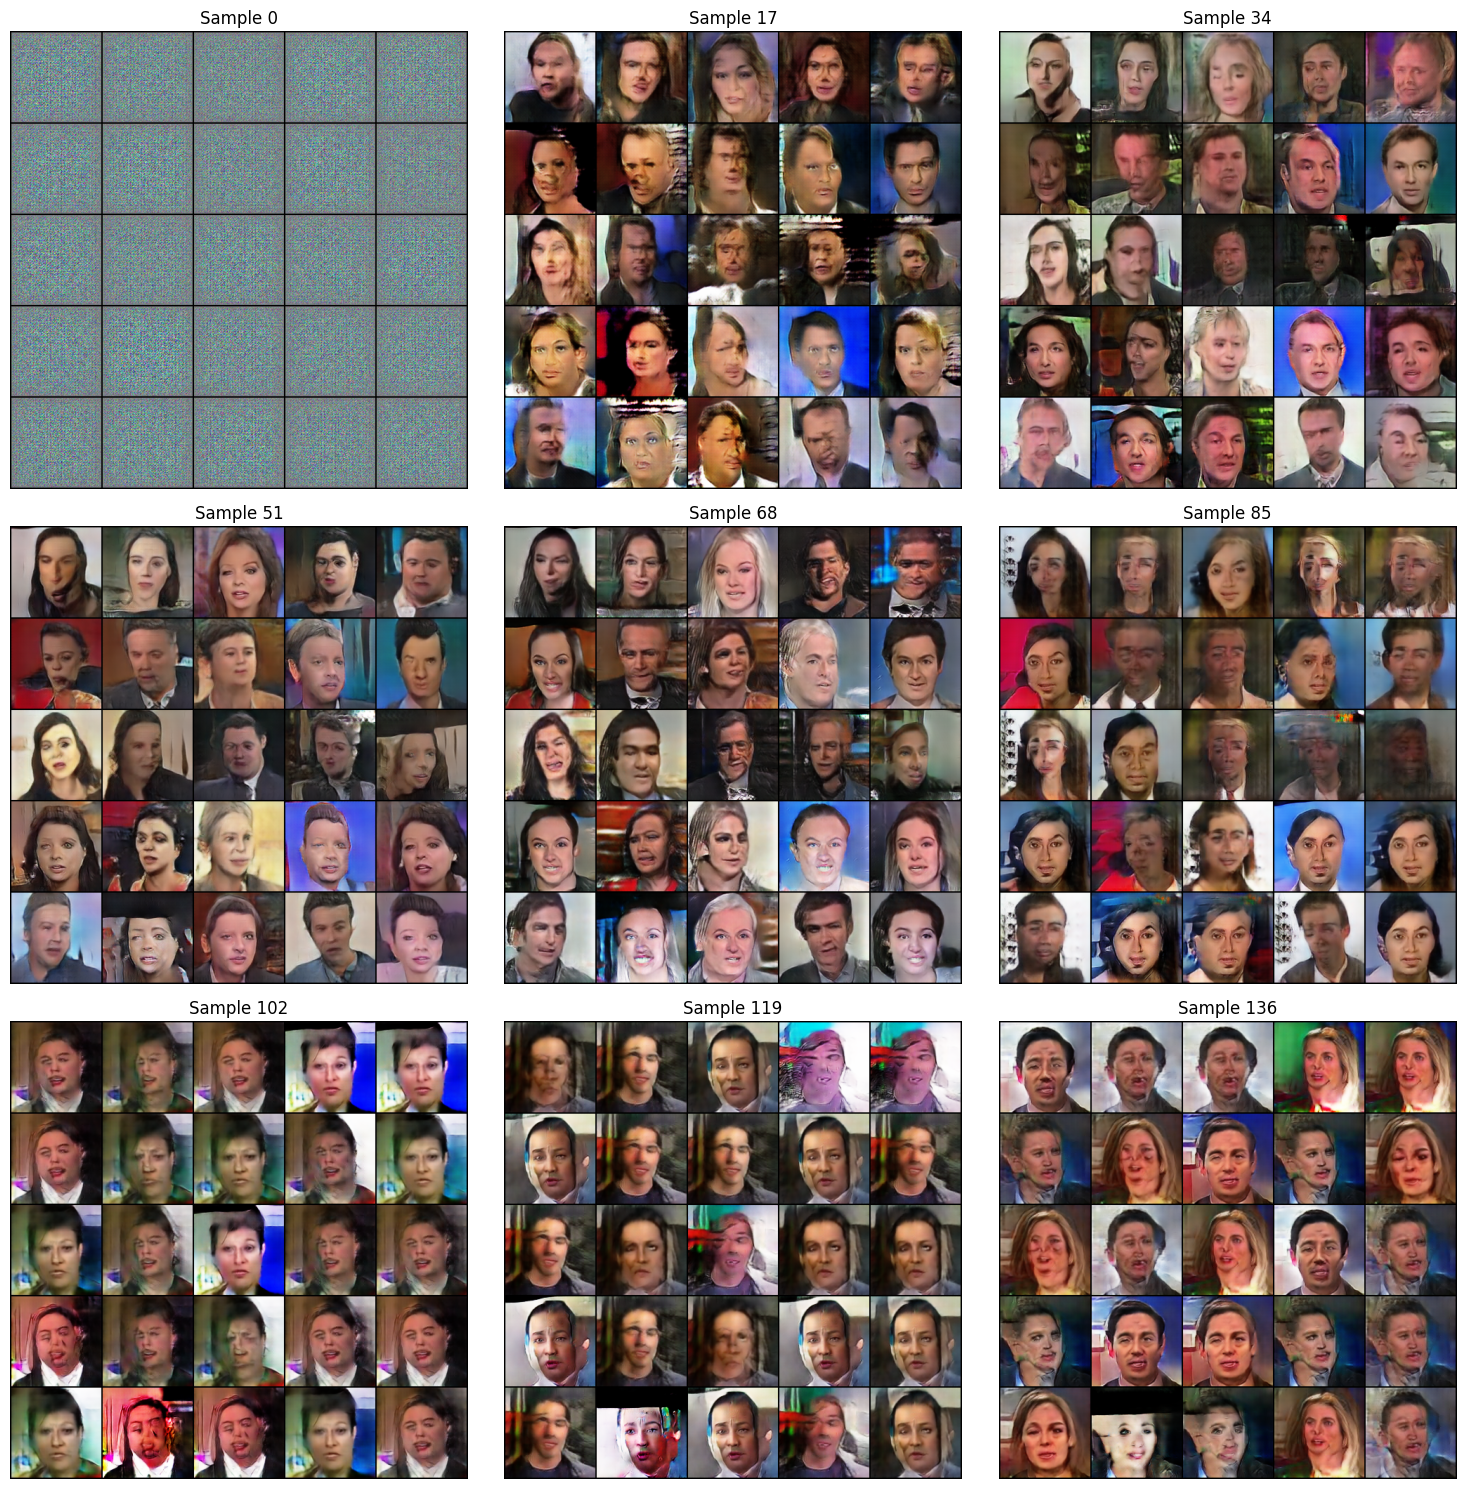

Saved training progress visualization to c:\Users\vinay\Documents\mnist\output\training_progress.png


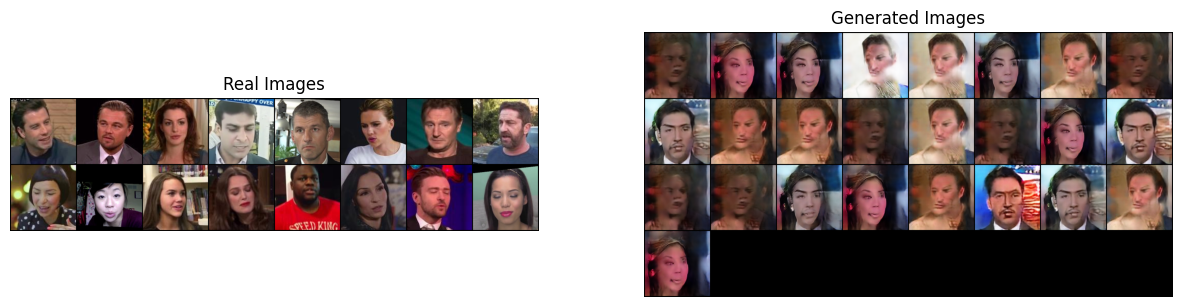

In [ ]:
###############################################################################
# CELL 13: VISUALIZATIONS
###############################################################################
"""
Result Visualizations
------------------
Generate visualizations of training progress, loss curves,
and sample images from the trained generator.
"""
# Plot loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(OUTPUT_PATH, "loss_curves.png"))
plt.show()

# Visualize training progress images
def visualize_training_progress(img_list, output_path, title="Training Progress"):
    """Create a grid of generated images showing progression"""
    if not img_list:
        print("No images available for progress visualization")
        return None
        
    # Select evenly spaced samples to show progression
    num_samples = min(9, len(img_list))
    step = max(1, len(img_list) // num_samples)
    samples = [img_list[i] for i in range(0, len(img_list), step)][:num_samples]
    
    # Create a grid
    rows = int(np.sqrt(len(samples)))
    cols = int(np.ceil(len(samples) / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, img in enumerate(samples):
        if i < len(axes):
            sample_num = i * step
            if sample_num >= len(img_list):
                sample_num = len(img_list) - 1
            axes[i].imshow(np.transpose(img, (1, 2, 0)))
            axes[i].set_title(f"Sample {sample_num}")
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    filepath = os.path.join(output_path, "training_progress.png")
    plt.savefig(filepath)
    plt.show()
    print(f"Saved training progress visualization to {filepath}")
    return filepath

# Show progress if we have multiple images
if len(img_list) > 1:
    visualize_training_progress(img_list, OUTPUT_PATH)

# Final visualization: Real vs Generated
real_batch = next(iter(dataloader))[0][:16].to(device)

# Generate a batch of fake images
with torch.no_grad():
    fake_batch = netG(fixed_noise).detach().cpu()

# Plot real images vs fake images
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.cpu(), padding=2, normalize=True),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch, padding=2, normalize=True),(1,2,0)))
plt.savefig(os.path.join(OUTPUT_PATH, "final_comparison.png"))
plt.show()


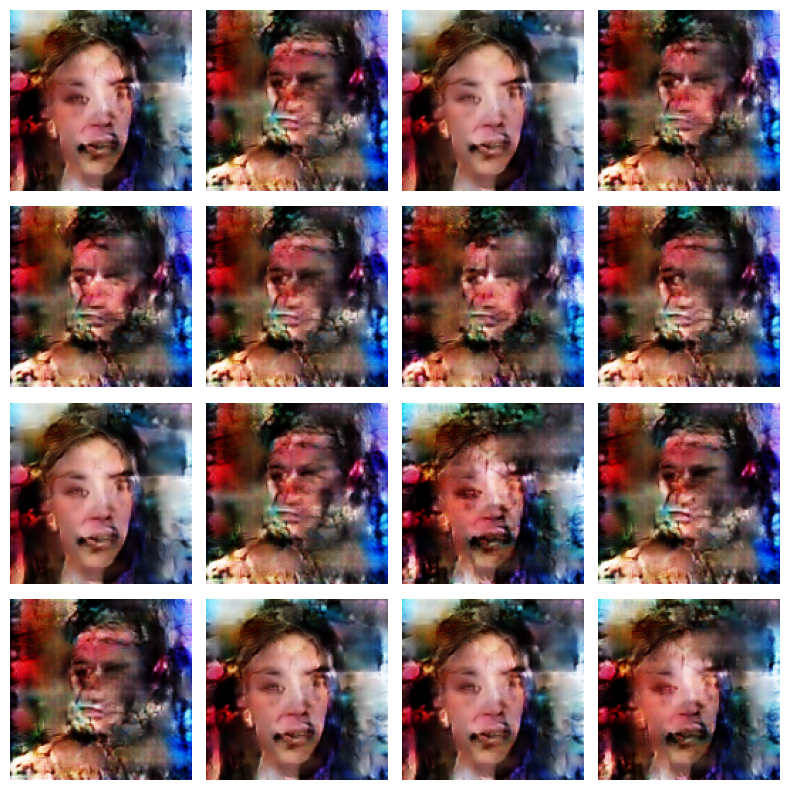

Generated 16 samples using the trained model


In [ ]:

###############################################################################
# CELL 14: GENERATE SAMPLES WITH TRAINED MODEL
###############################################################################
"""
Generate Samples with Trained Model
---------------------------------
Generate and visualize multiple samples using the trained generator.
This demonstrates how to use the model for inference.
"""
def generate_samples(netG, n_samples=16, grid_rows=4):
    """Generate multiple samples from the trained generator"""
    grid_cols = n_samples // grid_rows
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i in range(n_samples):
            # Generate a random latent vector
            z = torch.randn(1, Z_DIM, 1, 1, device=device)
            
            # Generate a fake image
            fake = netG(z).detach().cpu()
            
            # Display the image
            img = np.transpose(vutils.make_grid(fake, padding=0, normalize=True), (1, 2, 0))
            axes[i].imshow(img)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, "generated_samples.png"))
    plt.show()
    print(f"Generated {n_samples} samples using the trained model")

# Generate samples with the trained model
generate_samples(netG, n_samples=16, grid_rows=4)
